In [ ]:
!unzip -uq /content/drive/MyDrive/dataMMDS/datasets.zip

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp drive/MyDrive/MMDS-data/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
!echo $SPARK_HOME

/content/spark-3.1.1-bin-hadoop3.2


In [ ]:
import findspark
findspark.init()

##TASK 1


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext('local')
spark = SQLContext(sc)

In [ ]:
df = spark.read.csv('/content/datasets/mnist_small_test.csv') \
                .limit(1000)
df.show()

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
df.count()

1000

In [ ]:
from pyspark.sql.functions import col, array
from pyspark.ml.linalg import Vectors

dframe = df.rdd.map(lambda x: (x[0], Vectors.dense([float(it) for it in x[1:]])))\
           .toDF() \
           .select(col('_1').alias('label'), col('_2').alias('features'))
dframe.show()


+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[0.0,0.0,0.0,0.0,...|
|    2|[0.0,0.0,0.0,0.0,...|
|    2|[0.0,0.0,0.0,0.0,...|
|    5|[0.0,0.0,0.0,0.0,...|
|    8|[0.0,0.0,0.0,0.0,...|
|    1|[0.0,0.0,0.0,0.0,...|
|    3|[0.0,0.0,0.0,0.0,...|
|    2|[0.0,0.0,0.0,0.0,...|
|    9|[0.0,0.0,0.0,0.0,...|
|    4|[0.0,0.0,0.0,0.0,...|
|    3|[0.0,0.0,0.0,0.0,...|
|    8|[0.0,0.0,0.0,0.0,...|
|    2|[0.0,0.0,0.0,0.0,...|
|    2|[0.0,0.0,0.0,0.0,...|
|    1|[0.0,0.0,0.0,0.0,...|
|    2|[0.0,0.0,0.0,0.0,...|
|    8|[0.0,0.0,0.0,0.0,...|
|    6|[0.0,0.0,0.0,0.0,...|
|    5|[0.0,0.0,0.0,0.0,...|
|    1|[0.0,0.0,0.0,0.0,...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
dframe.printSchema()

root
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



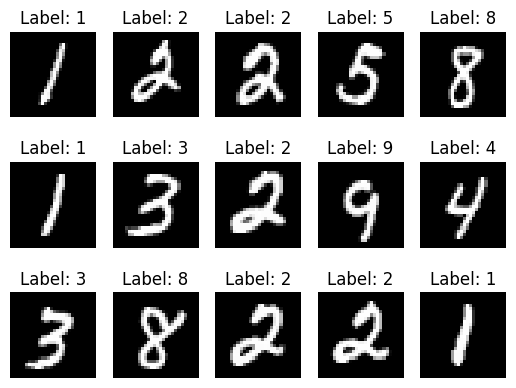

In [ ]:
from matplotlib import pyplot as plt

# Convert the 'features' column from a vector of 784 dimensions to a 28x28 matrix
data = dframe.select("features", "label").rdd.map(lambda row: (row.features.toArray().reshape(28, 28), row.label)).collect()

# Create a figure and axes for the subplots
fig, axes = plt.subplots(3, 5)

# Loop through the first 15 images and display them in the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i][0], cmap="gray")
    ax.set_title(f"Label: {data[i][1]}")
    ax.axis("off")

plt.show()

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler


In [ ]:
# !rm -r kmeans_model_k10
# !rm -r kmeans_model_k15
# !rm -r kmeans_model_k5

In [ ]:
# Register the function as a Spark SQL expression
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import math
# Initialize a list to store the sum of distances for each k
sum_of_distances_k5 = 0


kmeans = KMeans(k=5)
kmeans.setMaxIter(100)
model = kmeans.fit(dframe)
predictions = model.transform(dframe)
centers = model.clusterCenters()
predictions.show()


  # Save the model to files
model_path = "kmeans_model_k5"
model.save(model_path)
# Define a user-defined function to calculate the distance
def distance_udf(point, center):
  # Find the coordinates of the centroid
  centroid = centers[center]
  # Calculate the Euclidean distance between the point and the centroid
  distance = math.dist(point, centroid)
  return distance

distance_expr = udf(distance_udf, DoubleType())

# Add a new column to the predictions dataframe with the distance
predictions = predictions.withColumn('distance', distance_expr('features', 'prediction'))
predictions.show()

# Sum up the distances from the new column
sum_of_distances_k5 = predictions.select('distance').groupBy().sum().collect()[0][0]

# Print the result
print(f'The summation of Euclidean distance from each data point to its centroid is {sum_of_distances_k5}')

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|[0.0,0.0,0.0,0.0,...|         3|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    5|[0.0,0.0,0.0,0.0,...|         2|
|    8|[0.0,0.0,0.0,0.0,...|         2|
|    1|[0.0,0.0,0.0,0.0,...|         3|
|    3|[0.0,0.0,0.0,0.0,...|         2|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    9|[0.0,0.0,0.0,0.0,...|         1|
|    4|[0.0,0.0,0.0,0.0,...|         1|
|    3|[0.0,0.0,0.0,0.0,...|         2|
|    8|[0.0,0.0,0.0,0.0,...|         2|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    1|[0.0,0.0,0.0,0.0,...|         3|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    8|[0.0,0.0,0.0,0.0,...|         2|
|    6|[0.0,0.0,0.0,0.0,...|         0|
|    5|[0.0,0.0,0.0,0.0,...|         2|
|    1|[0.0,0.0,0.0,0.0,...|         3|
+-----+--------------------+----------+
only showing top 20 rows

+-----+-------

In [ ]:
# Register the function as a Spark SQL expression
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import math
# Initialize a list to store the sum of distances for each k
sum_of_distances_k10 = 0


kmeans = KMeans(k=10)
kmeans.setMaxIter(100)
model = kmeans.fit(dframe)
predictions = model.transform(dframe)
centers = model.clusterCenters()
predictions.show()


  # Save the model to files
model_path = "kmeans_model_k10"
model.save(model_path)
# Define a user-defined function to calculate the distance
def distance_udf(point, center):
  # Find the coordinates of the centroid
  centroid = centers[center]
  # Calculate the Euclidean distance between the point and the centroid
  distance = math.dist(point, centroid)
  return distance

distance_expr = udf(distance_udf, DoubleType())

# Add a new column to the predictions dataframe with the distance
predictions = predictions.withColumn('distance', distance_expr('features', 'prediction'))
predictions.show()

# Sum up the distances from the new column
sum_of_distances_k10 = predictions.select('distance').groupBy().sum().collect()[0][0]

# Print the result
print(f'The summation of Euclidean distance from each data point to its centroid is {sum_of_distances_k10}')

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|[0.0,0.0,0.0,0.0,...|         5|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    2|[0.0,0.0,0.0,0.0,...|         7|
|    5|[0.0,0.0,0.0,0.0,...|         0|
|    8|[0.0,0.0,0.0,0.0,...|         0|
|    1|[0.0,0.0,0.0,0.0,...|         5|
|    3|[0.0,0.0,0.0,0.0,...|         0|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    9|[0.0,0.0,0.0,0.0,...|         1|
|    4|[0.0,0.0,0.0,0.0,...|         2|
|    3|[0.0,0.0,0.0,0.0,...|         0|
|    8|[0.0,0.0,0.0,0.0,...|         7|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    1|[0.0,0.0,0.0,0.0,...|         5|
|    2|[0.0,0.0,0.0,0.0,...|         4|
|    8|[0.0,0.0,0.0,0.0,...|         7|
|    6|[0.0,0.0,0.0,0.0,...|         4|
|    5|[0.0,0.0,0.0,0.0,...|         0|
|    1|[0.0,0.0,0.0,0.0,...|         5|
+-----+--------------------+----------+
only showing top 20 rows

+-----+-------

In [ ]:
# Register the function as a Spark SQL expression
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import math
# Initialize a list to store the sum of distances for each k
sum_of_distances_k15 = 0


kmeans = KMeans(k=15)
kmeans.setMaxIter(100)
model = kmeans.fit(dframe)
predictions = model.transform(dframe)
centers = model.clusterCenters()
predictions.show()


  # Save the model to files
model_path = "kmeans_model_k15"
model.save(model_path)
# Define a user-defined function to calculate the distance
def distance_udf(point, center):
  # Find the coordinates of the centroid
  centroid = centers[center]
  # Calculate the Euclidean distance between the point and the centroid
  distance = math.dist(point, centroid)
  return distance

distance_expr = udf(distance_udf, DoubleType())

# Add a new column to the predictions dataframe with the distance
predictions = predictions.withColumn('distance', distance_expr('features', 'prediction'))
predictions.show()

# Sum up the distances from the new column
sum_of_distances_k15 = predictions.select('distance').groupBy().sum().collect()[0][0]

# Print the result
print(f'The summation of Euclidean distance from each data point to its centroid is {sum_of_distances_k15}')

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|[0.0,0.0,0.0,0.0,...|         8|
|    2|[0.0,0.0,0.0,0.0,...|         1|
|    2|[0.0,0.0,0.0,0.0,...|         1|
|    5|[0.0,0.0,0.0,0.0,...|         0|
|    8|[0.0,0.0,0.0,0.0,...|         7|
|    1|[0.0,0.0,0.0,0.0,...|         8|
|    3|[0.0,0.0,0.0,0.0,...|         0|
|    2|[0.0,0.0,0.0,0.0,...|         1|
|    9|[0.0,0.0,0.0,0.0,...|        10|
|    4|[0.0,0.0,0.0,0.0,...|        14|
|    3|[0.0,0.0,0.0,0.0,...|         7|
|    8|[0.0,0.0,0.0,0.0,...|         7|
|    2|[0.0,0.0,0.0,0.0,...|         1|
|    2|[0.0,0.0,0.0,0.0,...|         1|
|    1|[0.0,0.0,0.0,0.0,...|         8|
|    2|[0.0,0.0,0.0,0.0,...|         1|
|    8|[0.0,0.0,0.0,0.0,...|         7|
|    6|[0.0,0.0,0.0,0.0,...|        11|
|    5|[0.0,0.0,0.0,0.0,...|         3|
|    1|[0.0,0.0,0.0,0.0,...|        13|
+-----+--------------------+----------+
only showing top 20 rows

+-----+-------

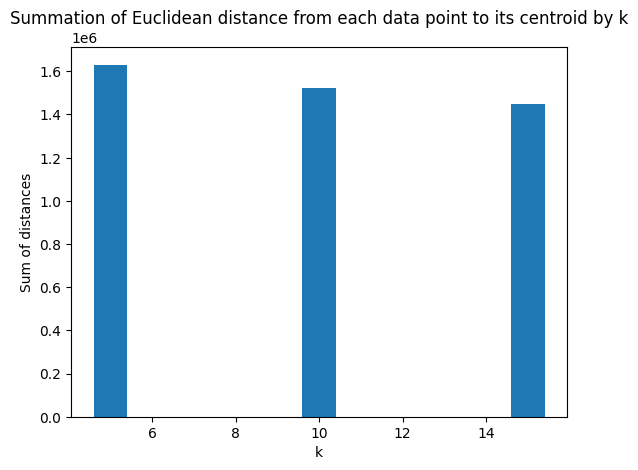

In [ ]:
import matplotlib.pyplot as plt
k_values = [5,10,15]
# print(sum_of_distances_k5)
# print(sum_of_distances_k10)
# print(sum_of_distances_k15)
sum_of_distances_list = []
sum_of_distances_list.extend((sum_of_distances_k5,sum_of_distances_k10,sum_of_distances_k15))
plt.bar(k_values, sum_of_distances_list)
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('Summation of Euclidean distance from each data point to its centroid by k')
plt.show()

##TASK 2


#2A

In [ ]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors
df = spark.read.option("header", False)\
      .option("delimiter",",")\
      .option("inferSchema", True)\
      .csv('/content/datasets/mnist_small_train.csv')
df.show()

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
# Convert the data to a RowMatrix
labels = df.rdd.map(lambda x: x[0]) # The first column is the label
vectors = df.rdd.map(lambda row: Vectors.dense(row[1:]))

In [ ]:
vectors.take(1)

[DenseVector([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
labels.take(2)

[7, 2]

In [ ]:
# vectors.take(2)

In [ ]:
mat = RowMatrix(vectors)
k = 196
svd = mat.computeSVD(k, computeU=True)

U = svd.U
s = svd.s #U.s to create embedding
V = svd.V

In [ ]:
import numpy as np

U_array = np.array(U.rows.collect())
s_array = np.array(s)
s_matrix = np.diag(s_array)
U_s = np.dot(U_array,s_matrix)

In [ ]:
U_s_matrix = sc.parallelize(U_s)

In [ ]:
U_s_matrix.take(5)

[array([-1.05500532e+03,  2.48244718e+02, -5.98132258e+02, -7.17796850e-01,
         3.85242274e+02,  5.72808262e+02,  2.67941212e+02,  6.63100448e+02,
        -9.02261518e+01, -1.89346264e+02,  9.15439120e+01, -3.75066601e+02,
        -1.03805239e+02, -6.70740188e+01, -1.03037855e+02, -1.64507349e+02,
         2.54156507e+02,  7.67661853e+01,  2.80547326e+01, -7.93840841e+01,
         2.48846352e+02, -1.97532178e+02, -2.15962429e+02,  1.16888104e+01,
         5.35187491e+01, -3.95959555e+01,  2.21746583e+01,  1.20605814e+02,
        -7.12717012e+01,  3.44713621e+02, -5.12664335e+00,  2.43667268e+02,
        -3.71482494e+01,  3.44695046e-03, -4.88689313e-01,  6.82314310e+01,
         7.74894405e+01, -2.12564664e+01,  5.65124902e+01,  1.17161006e+02,
         2.72808112e+02, -9.48905038e+00,  1.61260506e+02,  7.67570996e+01,
         3.03482388e+01,  5.03661258e+01,  1.46782944e+02,  1.07801724e+02,
        -8.36253542e+01,  8.74718125e+01,  8.79646571e+01, -4.59608794e+01,
        -1.6

In [ ]:
import pandas as pd
# convert U_s to a dataframe
U_s_df = pd.DataFrame(U_s)
# view the dataframe
U_s_df

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,-1055.005321,248.244718,-598.132258,-0.717797,385.242274,572.808262,267.941212,663.100448,-90.226152,-189.346264,...,-23.543177,34.110743,-15.606965,-20.631938,8.597066,-8.789588,-4.845129,6.202333,-16.364380,13.706236
1,-1393.004031,-133.681947,1018.332204,81.291235,-277.464165,-392.264988,293.510614,155.637172,-313.423289,15.827310,...,-7.612826,-40.288053,17.203241,42.341350,1.286444,-0.734451,-5.639195,5.603011,-8.283797,26.110131
2,-648.809758,549.281895,487.342624,288.599795,-79.728968,224.800368,188.461602,-302.132471,-132.090634,-149.062779,...,-16.457971,-29.706866,4.981351,-33.297987,-3.122522,-16.377859,-17.554461,-0.959679,-66.913474,4.950464
3,-2246.001287,-900.448759,-35.891545,188.103162,617.892539,-212.266997,548.128325,413.781602,70.004273,-435.183543,...,-14.135536,11.843813,-14.483327,-44.242483,23.311800,53.192239,17.504700,-10.746135,11.010311,-43.243824
4,-1106.075886,-451.020604,-814.494302,40.166073,-410.897242,8.945943,-268.763500,66.370419,-44.909915,145.110516,...,-0.796445,-64.286787,57.094652,47.804945,3.099986,37.065951,-1.022231,2.797097,-41.107464,-60.042840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,-1361.527432,301.652469,-394.134595,607.092674,98.815843,-175.863989,-576.632165,-331.547458,-259.584171,-404.678329,...,19.670387,15.249457,-28.701830,19.278263,-48.651046,-58.915816,34.926794,-8.956225,-13.414495,-36.028884
6996,-1326.202228,712.617455,-506.453987,183.673109,316.255873,35.445115,7.813972,65.530325,344.880790,-278.120200,...,5.002001,-16.268772,-9.785164,-2.573121,1.002456,-1.246706,-2.913784,-7.846777,-35.670503,21.054412
6997,-1368.608628,804.714173,110.261574,187.989534,226.395297,43.804819,-280.780714,-395.730519,-91.576037,-446.120384,...,-14.909392,-4.812660,24.616509,-10.440432,-34.558074,-27.403941,34.063880,-19.137246,-26.908348,-19.584852
6998,-1661.566897,547.111909,-643.050432,385.335951,574.413094,22.622496,-210.931038,-41.818571,329.371861,-247.051073,...,-50.205658,-28.515700,-34.058518,39.692646,-2.798577,49.720054,18.607466,39.383073,-42.158037,15.302131


In [ ]:
# convert labels to a dataframe
labels_df = pd.DataFrame(labels.collect())
# join labels_df and U_s_df
joined_df = pd.concat([labels_df, U_s_df], axis=1)
joined_df.to_csv('mnist_small_train_svd.csv')


In [ ]:
# !rm -rf mnist_small_train_svd.csv

In [ ]:
joined_df


,0,0,1,2,3,4,5,6,7,8,...,186,187,188,189,190,191,192,193,194,195
0,7,-1055.005321,248.244718,-598.132258,-0.717797,385.242274,572.808262,267.941212,663.100448,-90.226152,...,-23.543177,34.110743,-15.606965,-20.631938,8.597066,-8.789588,-4.845129,6.202333,-16.364380,13.706236
1,2,-1393.004031,-133.681947,1018.332204,81.291235,-277.464165,-392.264988,293.510614,155.637172,-313.423289,...,-7.612826,-40.288053,17.203241,42.341350,1.286444,-0.734451,-5.639195,5.603011,-8.283797,26.110131
2,1,-648.809758,549.281895,487.342624,288.599795,-79.728968,224.800368,188.461602,-302.132471,-132.090634,...,-16.457971,-29.706866,4.981351,-33.297987,-3.122522,-16.377859,-17.554461,-0.959679,-66.913474,4.950464
3,0,-2246.001287,-900.448759,-35.891545,188.103162,617.892539,-212.266997,548.128325,413.781602,70.004273,...,-14.135536,11.843813,-14.483327,-44.242483,23.311800,53.192239,17.504700,-10.746135,11.010311,-43.243824
4,4,-1106.075886,-451.020604,-814.494302,40.166073,-410.897242,8.945943,-268.763500,66.370419,-44.909915,...,-0.796445,-64.286787,57.094652,47.804945,3.099986,37.065951,-1.022231,2.797097,-41.107464,-60.042840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4,-1361.527432,301.652469,-394.134595,607.092674,98.815843,-175.863989,-576.632165,-331.547458,-259.584171,...,19.670387,15.249457,-28.701830,19.278263,-48.651046,-58.915816,34.926794,-8.956225,-13.414495,-36.028884
6996,9,-1326.202228,712.617455,-506.453987,183.673109,316.255873,35.445115,7.813972,65.530325,344.880790,...,5.002001,-16.268772,-9.785164,-2.573121,1.002456,-1.246706,-2.913784,-7.846777,-35.670503,21.054412
6997,4,-1368.608628,804.714173,110.261574,187.989534,226.395297,43.804819,-280.780714,-395.730519,-91.576037,...,-14.909392,-4.812660,24.616509,-10.440432,-34.558074,-27.403941,34.063880,-19.137246,-26.908348,-19.584852
6998,9,-1661.566897,547.111909,-643.050432,385.335951,574.413094,22.622496,-210.931038,-41.818571,329.371861,...,-50.205658,-28.515700,-34.058518,39.692646,-2.798577,49.720054,18.607466,39.383073,-42.158037,15.302131


#2B

In [ ]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors
data = spark.read.option("header", False)\
      .option("delimiter",",")\
      .option("inferSchema", True)\
      .csv('/content/datasets/mnist_small_test.csv')
data.show()

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
# Convert the data to a RowMatrix
labels = data.rdd.map(lambda x: x[0]) # The first column is the label
vectors = data.rdd.map(lambda row: Vectors.dense(row[1:]))
labels.take(2)

[1, 2]

In [ ]:
# vectors.take(2)

In [ ]:
mat = RowMatrix(vectors)
k = 196
svd = mat.computeSVD(k, computeU=True)

U = svd.U
s = svd.s #U.s to create embedding
V = svd.V

In [ ]:
import numpy as np

U_array = np.array(U.rows.collect())
s_array = np.array(s)
s_matrix = np.diag(s_array)
U_s = np.dot(U_array,s_matrix)

In [ ]:
U_s_matrix = sc.parallelize(U_s)

In [ ]:
U_s_matrix.take(5)

[array([-7.19336823e+02, -5.17676027e+02, -5.60968574e+02, -2.44345334e+02,
         2.11322198e+02,  1.07687917e+02,  3.79441332e+02, -2.68722818e+02,
        -3.23818805e+01, -1.23826404e+02, -2.48793015e+02, -4.79393998e+01,
         2.88023740e+02,  1.64395844e+02,  2.03715144e+02, -7.85136537e+01,
        -5.91135310e+01,  6.76588127e+01, -2.96744852e+02,  1.10036204e+02,
         5.82770639e+01, -9.17304857e+01,  1.98978344e+01,  5.81060506e+01,
         5.98379495e+01, -1.14818838e+02, -2.98701637e+01,  2.65759454e+01,
         1.58138654e+01, -1.69975523e+02, -9.50291687e+00, -1.80750015e+02,
        -4.08123207e+01,  8.39033674e+01,  1.29354674e+02,  1.21087446e+02,
         1.31247917e+02, -6.28909790e+01, -3.91377041e+01, -8.17179575e+01,
         5.86204804e+01, -4.86382987e+01,  8.30190445e+01, -1.20519820e+01,
         2.58247660e+01, -1.54870783e+01, -5.84741379e+01, -2.92158124e+01,
         3.68389693e+01, -1.34170134e+02,  2.99396723e+01,  4.89174479e+00,
         4.3

In [ ]:
import pandas as pd
# convert U_s to a dataframe
U_s_df = pd.DataFrame(U_s)
# view the dataframe
U_s_df

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,-719.336823,-517.676027,-560.968574,-244.345334,211.322198,107.687917,379.441332,-268.722818,-32.381880,-123.826404,...,-15.353932,-10.231971,-4.289851,0.000823,1.495255,-2.650962,10.209352,-19.052111,1.850610,-11.285406
1,-1705.390328,-266.338804,-332.129837,-623.960334,-2.108565,28.689877,19.115734,331.757521,-15.818638,406.076307,...,38.172199,-22.544177,22.772984,-19.780061,31.655997,17.252935,12.378097,-25.931362,-17.025510,16.399651
2,-2218.073320,47.072433,-21.154111,-184.794019,-117.336745,-264.275664,-170.836506,420.738637,663.817502,206.800549,...,-29.273811,-8.160999,23.571415,22.216686,-63.074914,-31.367024,-24.786606,4.925951,-13.658045,12.597392
3,-1752.024057,169.540720,-629.262360,702.153920,148.800581,630.382267,-371.175394,314.623464,110.137865,156.593667,...,-44.610519,13.542975,27.341046,-19.774472,-0.127146,-22.882538,42.999714,76.163333,-9.671932,-31.671808
4,-1591.575614,-676.191137,-423.445397,443.421250,-306.867662,100.827341,-172.311313,-299.983753,77.791082,291.068048,...,23.477545,39.762567,6.578987,-6.428617,-8.307246,-25.940090,31.638274,-13.557286,-37.372791,28.895573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-2209.420379,-390.750455,-614.307996,-8.128519,-650.550997,-780.804666,532.855222,537.387195,520.549227,-142.629908,...,57.865418,-25.378515,30.358551,-6.454907,-23.476244,2.859269,-56.106334,-2.409283,25.696756,-6.911808
2996,-1917.403906,241.552251,-699.503750,909.245345,-624.867327,303.093117,545.209046,566.463195,28.126048,-166.848914,...,-29.421510,-9.201433,-45.971200,-20.074695,-2.566481,-16.372978,-3.795789,-50.479452,-42.403631,-11.405306
2997,-1971.165299,-721.780966,690.089932,-212.919595,22.253756,5.356001,-356.491504,-48.767773,164.695212,-669.976246,...,46.752490,51.274721,-8.072673,57.798876,-17.248856,-54.190421,-30.914524,29.563438,-5.222798,-40.599537
2998,-1578.276037,-233.523411,-23.952617,-253.942674,575.375673,557.814322,61.171699,-23.487043,-201.137084,-132.812078,...,-51.511079,-19.152904,59.717472,-21.535225,8.325068,9.126746,49.947855,-11.676049,-14.068177,-19.396145


In [ ]:
# convert labels to a dataframe
labels_df = pd.DataFrame(labels.collect())
# join labels_df and U_s_df
joined_df = pd.concat([labels_df, U_s_df], axis=1)
joined_df.to_csv('mnist_small_test_svd.csv')


In [ ]:
# view the joined dataframe
joined_df

,0,0,1,2,3,4,5,6,7,8,...,186,187,188,189,190,191,192,193,194,195
0,1,-719.336823,-517.676027,-560.968574,-244.345334,211.322198,107.687917,379.441332,-268.722818,-32.381880,...,-15.353932,-10.231971,-4.289851,0.000823,1.495255,-2.650962,10.209352,-19.052111,1.850610,-11.285406
1,2,-1705.390328,-266.338804,-332.129837,-623.960334,-2.108565,28.689877,19.115734,331.757521,-15.818638,...,38.172199,-22.544177,22.772984,-19.780061,31.655997,17.252935,12.378097,-25.931362,-17.025510,16.399651
2,2,-2218.073320,47.072433,-21.154111,-184.794019,-117.336745,-264.275664,-170.836506,420.738637,663.817502,...,-29.273811,-8.160999,23.571415,22.216686,-63.074914,-31.367024,-24.786606,4.925951,-13.658045,12.597392
3,5,-1752.024057,169.540720,-629.262360,702.153920,148.800581,630.382267,-371.175394,314.623464,110.137865,...,-44.610519,13.542975,27.341046,-19.774472,-0.127146,-22.882538,42.999714,76.163333,-9.671932,-31.671808
4,8,-1591.575614,-676.191137,-423.445397,443.421250,-306.867662,100.827341,-172.311313,-299.983753,77.791082,...,23.477545,39.762567,6.578987,-6.428617,-8.307246,-25.940090,31.638274,-13.557286,-37.372791,28.895573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2,-2209.420379,-390.750455,-614.307996,-8.128519,-650.550997,-780.804666,532.855222,537.387195,520.549227,...,57.865418,-25.378515,30.358551,-6.454907,-23.476244,2.859269,-56.106334,-2.409283,25.696756,-6.911808
2996,3,-1917.403906,241.552251,-699.503750,909.245345,-624.867327,303.093117,545.209046,566.463195,28.126048,...,-29.421510,-9.201433,-45.971200,-20.074695,-2.566481,-16.372978,-3.795789,-50.479452,-42.403631,-11.405306
2997,4,-1971.165299,-721.780966,690.089932,-212.919595,22.253756,5.356001,-356.491504,-48.767773,164.695212,...,46.752490,51.274721,-8.072673,57.798876,-17.248856,-54.190421,-30.914524,29.563438,-5.222798,-40.599537
2998,5,-1578.276037,-233.523411,-23.952617,-253.942674,575.375673,557.814322,61.171699,-23.487043,-201.137084,...,-51.511079,-19.152904,59.717472,-21.535225,8.325068,9.126746,49.947855,-11.676049,-14.068177,-19.396145


#TASK 3

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row



In [ ]:
lines = spark.read.text("/content/datasets/ratings2k.csv").rdd
header = lines.first()
lines = lines.filter(lambda line: line != header)
parts = lines.map(lambda row: row.value.split(","))
ratingsRDD = parts.map(lambda p: Row(index=int(p[0]), user=int(p[1]),
                                     item=int(p[2]), rating=float(p[3])))
ratings = spark.createDataFrame(ratingsRDD)

In [ ]:
ratings.show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0|
|    6|  72| 426|   4.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|    9|  59|  22|   3.5|
|   10|   8| 174|   2.0|
|   11|   5| 149|   2.0|
|   12|  26| 322|   3.5|
|   13|   8| 416|   4.0|
|   14|  31|  25|   2.0|
|   15|  41|  83|   2.0|
|   16|  25| 321|   3.0|
|   17|  47| 193|   3.0|
|   18|   9| 455|   4.0|
|   19|  43| 216|   3.5|
+-----+----+----+------+
only showing top 20 rows



In [ ]:
training = ratings.orderBy("user")
training.show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|  390|   1| 352|   5.0|
|   32|   1| 167|   3.5|
| 1188|   1| 168|   5.0|
|  130|   1| 422|   3.5|
| 1544|   1| 163|   5.0|
|  674|   2| 288|   5.0|
| 1568|   2| 216|   1.0|
|  482|   2| 251|   5.0|
|  757|   2| 204|   4.5|
|   50|   2| 413|   3.5|
| 1108|   2| 310|   2.0|
|  139|   2| 183|   5.0|
| 1274|   2| 199|   4.5|
| 1485|   2| 271|   4.0|
| 1622|   2| 294|   4.5|
| 1097|   2|  82|   4.5|
| 1180|   2| 176|   5.0|
| 1213|   2|   0|   3.5|
| 1399|   2| 320|   2.0|
|  238|   2| 434|   4.0|
+-----+----+----+------+
only showing top 20 rows



In [ ]:
test = training.filter((ratings.user >= 71) & (ratings.item >= 401))
test.show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    6|  72| 426|   4.0|
|   41|  72| 435|   4.0|
|  157|  72| 444|   3.0|
|  200|  72| 447|   4.0|
|  324|  72| 460|   3.0|
|  375|  72| 433|   4.0|
|  631|  72| 466|   1.0|
|  694|  72| 440|   3.0|
|  797|  72| 446|   2.0|
|  843|  72| 406|   2.0|
|  961|  72| 427|   4.0|
| 1035|  72| 437|   5.0|
| 1071|  72| 457|   4.0|
| 1176|  72| 434|   4.0|
| 1192|  72| 421|   4.0|
| 1228|  72| 432|   5.0|
| 1413|  72| 464|   5.0|
| 1501|  72| 413|   5.0|
| 1530|  72| 454|   5.0|
| 1585|  72| 412|   3.0|
+-----+----+----+------+
only showing top 20 rows



In [ ]:
als = ALS(maxIter=10,regParam=0.01,userCol="user",
          itemCol="item",
          ratingCol="rating",coldStartStrategy="drop")
model = als.fit(training)

In [ ]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating",
                                predictionCol="prediction")
mse = evaluator.evaluate(predictions)
print("Mean-square error = " + str(mse))

Mean-square error = 0.008761717544396164


In [ ]:
userRecs = model.recommendForAllUsers(10)
userRecs.show()

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|  31|[{429, 4.5725656}...|
|  65|[{176, 0.9997872}...|
|  53|[{431, 5.7010565}...|
|  34|[{322, 8.995621},...|
|  28|[{93, 6.0453105},...|
|  26|[{422, 5.6205425}...|
|  27|[{232, 6.3431525}...|
|  44|[{36, 4.7086453},...|
|  12|[{99, 5.037675}, ...|
|  22|[{18, 6.789221}, ...|
|  47|[{18, 5.0965533},...|
|   1|[{438, 8.362517},...|
|  13|[{199, 5.4361563}...|
|   6|[{385, 5.444251},...|
|  16|[{437, 5.0158825}...|
|   3|[{18, 5.881097}, ...|
|  20|[{385, 6.4164877}...|
|  40|[{335, 6.845228},...|
|  57|[{432, 5.244834},...|
|  54|[{385, 6.8629804}...|
+----+--------------------+
only showing top 20 rows



#TASK 4


In [ ]:
from pyspark.sql.functions import lag, collect_list, to_date, lit, col, concat_ws, array
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
data = spark.read.csv('/content/datasets/stockHVN2022.csv', header=True, inferSchema=True)
data = data.withColumn('Ngay', to_date('Ngay', 'dd/MM/yyyy'))
data.head(5)

[Row(Ngay=datetime.date(2022, 11, 18), HVN=9.3),
 Row(Ngay=datetime.date(2022, 11, 17), HVN=9.42),
 Row(Ngay=datetime.date(2022, 11, 16), HVN=9.21),
 Row(Ngay=datetime.date(2022, 11, 15), HVN=8.61),
 Row(Ngay=datetime.date(2022, 11, 14), HVN=9.25)]

In [ ]:
# Split the data into training and test sets
train_data = data.filter(col('Ngay') < to_date(lit('01-07-2022'), 'dd-MM-yyyy'))
test_data = data.filter(col('Ngay') >= to_date(lit('01-07-2022'), 'dd-MM-yyyy'))

# Define a window specification to get the previous 5 prices
window_spec = Window.orderBy('Ngay').rowsBetween(-5, -1)

# Create the training dataframe
train_df = train_data.select(collect_list('HVN').over(window_spec).alias('Prices of 05 previous dates'), 'HVN').filter('size(`Prices of 05 previous dates`) == 5')

# Create the test dataframe
test_df = test_data.select(collect_list('HVN').over(window_spec).alias('Prices of 05 previous dates'), 'HVN').filter('size(`Prices of 05 previous dates`) == 5')

# Define the feature and label columns
feature_cols = ['Prices of 05 previous dates']
label_col = 'Today price'

In [ ]:
data.printSchema()

root
 |-- Ngay: date (nullable = true)
 |-- HVN: double (nullable = true)



In [ ]:
print(train_data.count())
train_data.show(5)

120
+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|2022-06-30| 15.5|
|2022-06-29|16.05|
|2022-06-28| 16.5|
|2022-06-27| 16.3|
|2022-06-24|15.25|
+----------+-----+
only showing top 5 rows



In [ ]:
print(test_data.count())
test_data.show(5)

99
+----------+----+
|      Ngay| HVN|
+----------+----+
|2022-11-18| 9.3|
|2022-11-17|9.42|
|2022-11-16|9.21|
|2022-11-15|8.61|
|2022-11-14|9.25|
+----------+----+
only showing top 5 rows



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf

# Define a UDF to convert the array to a vector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

In [ ]:
# Apply the UDF to create a new column with vectors
train_df = train_df.select(array_to_vector_udf("Prices of 05 previous dates").alias("Prices of 05 previous dates"),'HVN')

# Show the resulting DataFrame
train_df.show()

+---------------------------+-----+
|Prices of 05 previous dates|  HVN|
+---------------------------+-----+
|       [23.3,23.1,22.85,...|23.05|
|       [23.1,22.85,22.65...|22.95|
|       [22.85,22.65,23.2...|22.65|
|       [22.65,23.2,23.05...| 22.7|
|       [23.2,23.05,22.95...| 22.9|
|       [23.05,22.95,22.6...|22.95|
|       [22.95,22.65,22.7...| 22.7|
|       [22.65,22.7,22.9,...|22.75|
|       [22.7,22.9,22.95,...| 22.7|
|       [22.9,22.95,22.7,...| 22.8|
|       [22.95,22.7,22.75...|23.35|
|       [22.7,22.75,22.7,...| 24.1|
|       [22.75,22.7,22.8,...| 24.0|
|       [22.7,22.8,23.35,...| 24.3|
|       [22.8,23.35,24.1,...| 26.0|
|       [23.35,24.1,24.0,...| 26.0|
|       [24.1,24.0,24.3,2...|26.25|
|       [24.0,24.3,26.0,2...| 26.4|
|       [24.3,26.0,26.0,2...| 26.2|
|       [26.0,26.0,26.25,...| 26.4|
+---------------------------+-----+
only showing top 20 rows



In [ ]:
# Apply the UDF to create a new column with vectors
test_df = test_df.select(array_to_vector_udf("Prices of 05 previous dates").alias("Prices of 05 previous dates"),'HVN')

# Show the resulting DataFrame
test_df.head(5)

[Row(Prices of 05 previous dates=DenseVector([15.6, 15.75, 15.45, 15.6, 15.65]), HVN=16.35),
 Row(Prices of 05 previous dates=DenseVector([15.75, 15.45, 15.6, 15.65, 16.35]), HVN=16.3),
 Row(Prices of 05 previous dates=DenseVector([15.45, 15.6, 15.65, 16.35, 16.3]), HVN=16.35),
 Row(Prices of 05 previous dates=DenseVector([15.6, 15.65, 16.35, 16.3, 16.35]), HVN=16.45),
 Row(Prices of 05 previous dates=DenseVector([15.65, 16.35, 16.3, 16.35, 16.45]), HVN=16.45)]

In [ ]:
train_df.write.json("train_df.json", mode="overwrite")
test_df.write.json("test_df.json", mode="overwrite")

In [ ]:
train_df.printSchema()

root
 |-- Prices of 05 previous dates: vector (nullable = true)
 |-- HVN: double (nullable = true)



In [ ]:
# Vectorize the features
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

In [ ]:
# Build the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='HVN')
lr_model = lr.fit(train_df)

# Save the model to files
lr_model.write().overwrite().save('linear_regression_model')

# Load the model from files
loaded_lr_model = LinearRegressionModel.load('linear_regression_model')

# Make predictions on the training and test sets
train_pred = loaded_lr_model.transform(train_df)
test_pred = loaded_lr_model.transform(test_df)

# Compute the Mean Square Error
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='HVN', metricName='mse')
train_mse = evaluator.evaluate(train_pred)
test_mse = evaluator.evaluate(test_pred)

# Print the Mean Square Error
print('Training MSE:', train_mse)
print('Test MSE:', test_mse)

Training MSE: 0.2448820907085194
Test MSE: 0.11201926409027205


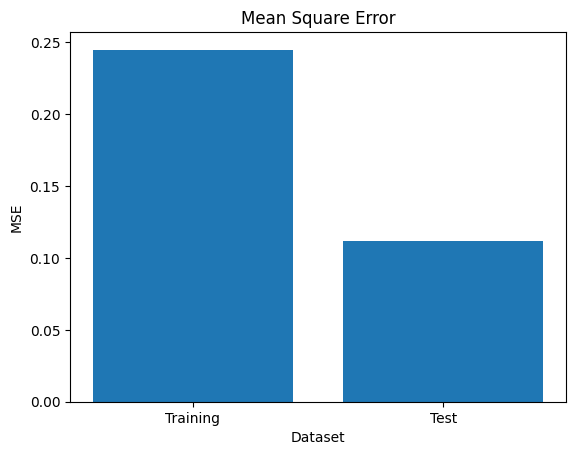

In [ ]:
import matplotlib.pyplot as plt

# Plot the Mean Square Errors in a bar chart
plt.bar(['Training', 'Test'], [train_mse, test_mse])
plt.title('Mean Square Error')
plt.xlabel('Dataset')
plt.ylabel('MSE')
plt.show()


#TASK 5

In [ ]:
# import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer

In [ ]:
df_mninst_small_train_or = spark.read\
        .option('header', False)\
        .option('inferSchema', True)\
        .csv('/content/datasets/mnist_small_train.csv')

In [ ]:
df_mninst_small_test_or = spark.read\
        .option('header', False)\
        .option('inferSchema', True)\
        .csv('/content/datasets/mnist_small_test.csv')

In [ ]:
# import original dataset
train = df_mninst_small_train_or
test = df_mninst_small_test_or

In [ ]:
# import train_svd data
mninst_small_train_svd = spark.read\
        .option('header', False)\
        .option('inferSchema', True)\
        .csv('mnist_small_train_svd.csv')

In [ ]:
mninst_small_train_svd = mninst_small_train_svd.filter(mninst_small_train_svd['_c0'] != 1)
mninst_small_train_svd = mninst_small_train_svd.drop('_c0')
mninst_small_train_svd.show()

+---+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------

In [ ]:
# import test_svd data
mninst_small_test_svd = spark.read\
        .option('header', False)\
        .option('inferSchema', True)\
        .csv('mnist_small_test_svd.csv')

In [ ]:
mninst_small_test_svd = mninst_small_test_svd.filter(mninst_small_test_svd['_c0'] != 1)
mninst_small_test_svd = mninst_small_test_svd.drop('_c0')
mninst_small_test_svd.show()

+---+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------

# Support functions

In [ ]:
# function to assembler data
def preprocess_data(data):
  assembler_input = data.columns[1:]
  vector_assembler = VectorAssembler(inputCols=assembler_input, outputCol="features")
  return vector_assembler.transform(data)

In [ ]:
# function to label_index
def label_index(data):
  label_indexer = StringIndexer(inputCol="_c0", outputCol="labelIndex")
  return label_indexer.fit(data)

# Preprocess original dataset

In [ ]:
# amssembler trainset
amssembler_trainset = preprocess_data(train)
amssembler_trainset.show(5)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
# amssembler testset
amssembler_testset = preprocess_data(test)
amssembler_testset.show(5)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
# get _c0 and features in trainset
amssembler_trainset = amssembler_trainset.select("_c0", "features")
amssembler_trainset.show(5)

+---+--------------------+
|_c0|            features|
+---+--------------------+
|  7|(784,[202,203,204...|
|  2|(784,[94,95,96,97...|
|  1|(784,[128,129,130...|
|  0|(784,[124,125,126...|
|  4|(784,[150,151,159...|
+---+--------------------+
only showing top 5 rows



In [ ]:
# get _c0 and features in testset
amssembler_testset = amssembler_testset.select("_c0", "features")
amssembler_testset.show(5)

+---+--------------------+
|_c0|            features|
+---+--------------------+
|  1|(784,[128,129,130...|
|  2|(784,[100,101,102...|
|  2|(784,[125,126,127...|
|  5|(784,[126,127,128...|
|  8|(784,[151,152,153...|
+---+--------------------+
only showing top 5 rows



In [ ]:
# combine the two datasets
combined_data = amssembler_trainset.union(amssembler_testset)

In [ ]:
# fit the StringIndexer on the combined data
fitted_indexer = label_index(combined_data)

In [ ]:
# transform the train dataset using the fitted indexer
indexed_trainset = fitted_indexer.transform(amssembler_trainset)
# transform the test dataset using the fitted indexer
indexed_testset = fitted_indexer.transform(amssembler_testset)

In [ ]:
# dataset_train = label_index(amssembler_trainset)
indexed_trainset.show(10)

+---+--------------------+----------+
|_c0|            features|labelIndex|
+---+--------------------+----------+
|  7|(784,[202,203,204...|       2.0|
|  2|(784,[94,95,96,97...|       1.0|
|  1|(784,[128,129,130...|       0.0|
|  0|(784,[124,125,126...|       6.0|
|  4|(784,[150,151,159...|       5.0|
|  1|(784,[156,157,158...|       0.0|
|  4|(784,[149,150,151...|       5.0|
|  9|(784,[179,180,181...|       4.0|
|  5|(784,[129,130,131...|       9.0|
|  9|(784,[209,210,211...|       4.0|
+---+--------------------+----------+
only showing top 10 rows



In [ ]:
indexed_testset.show(10)

+---+--------------------+----------+
|_c0|            features|labelIndex|
+---+--------------------+----------+
|  1|(784,[128,129,130...|       0.0|
|  2|(784,[100,101,102...|       1.0|
|  2|(784,[125,126,127...|       1.0|
|  5|(784,[126,127,128...|       9.0|
|  8|(784,[151,152,153...|       7.0|
|  1|(784,[127,128,129...|       0.0|
|  3|(784,[122,123,124...|       3.0|
|  2|(784,[99,100,101,...|       1.0|
|  9|(784,[179,180,181...|       4.0|
|  4|(784,[159,160,161...|       5.0|
+---+--------------------+----------+
only showing top 10 rows



In [ ]:
indexed_trainset.select("labelIndex", "_c0").distinct().show()

+----------+---+
|labelIndex|_c0|
+----------+---+
|       3.0|  3|
|       4.0|  9|
|       1.0|  2|
|       8.0|  6|
|       2.0|  7|
|       0.0|  1|
|       9.0|  5|
|       7.0|  8|
|       6.0|  0|
|       5.0|  4|
+----------+---+



In [ ]:
indexed_testset.select("labelIndex", "_c0").distinct().show()

+----------+---+
|labelIndex|_c0|
+----------+---+
|       3.0|  3|
|       4.0|  9|
|       1.0|  2|
|       8.0|  6|
|       2.0|  7|
|       0.0|  1|
|       9.0|  5|
|       7.0|  8|
|       6.0|  0|
|       5.0|  4|
+----------+---+



# Support functions SVD

In [ ]:
# function to assembler data
def preprocess_data_svd(data):
  assembler_input = data.columns[1:]
  vector_assembler = VectorAssembler(inputCols=assembler_input, outputCol="features")
  return vector_assembler.transform(data)

In [ ]:
# function to label_index
def label_index_svd(data):
  label_indexer = StringIndexer(inputCol="_c1", outputCol="labelIndex")
  return label_indexer.fit(data)

#Preprocess svd dataset

In [ ]:
# amssembler trainset_svd
amssembler_trainset_svd = preprocess_data_svd(mninst_small_train_svd)
amssembler_trainset_svd.show(5)

+---+-------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------

In [ ]:
# amssembler testset_svd
amssembler_testset_svd = preprocess_data_svd(mninst_small_test_svd)
amssembler_testset_svd.show(5)

+---+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------

In [ ]:
# get _c0 and features in trainset_svd
amssembler_trainset_svd = amssembler_trainset_svd.select("_c1", "features")
amssembler_trainset_svd.show(5)

+---+--------------------+
|_c1|            features|
+---+--------------------+
|  7|[-1055.0053208724...|
|  1|[-648.80975831475...|
|  0|[-2246.0012873225...|
|  4|[-1106.0758861902...|
|  1|[-929.42510316532...|
+---+--------------------+
only showing top 5 rows



In [ ]:
# get _c0 and features in testset_svd
amssembler_testset_svd = amssembler_testset_svd.select("_c1", "features")
amssembler_testset_svd.show(5)

+---+--------------------+
|_c1|            features|
+---+--------------------+
|  1|[-719.33682312628...|
|  2|[-2218.0733201160...|
|  5|[-1752.0240571990...|
|  8|[-1591.5756140666...|
|  1|[-884.76004760889...|
+---+--------------------+
only showing top 5 rows



In [ ]:
# combine the two datasets_svd
combined_data_svd = amssembler_trainset_svd.union(amssembler_testset_svd)

In [ ]:
# fit the StringIndexer on the combined data svd
fitted_indexer_svd = label_index_svd(combined_data_svd)

In [ ]:
# transform the train dataset svd using the fitted indexer
indexed_trainset_svd = fitted_indexer_svd.transform(amssembler_trainset_svd)
# transform the test dataset svd using the fitted indexer
indexed_testset_svd = fitted_indexer_svd.transform(amssembler_testset_svd)

In [ ]:
# dataset_train = label_index(amssembler_trainset)
indexed_trainset_svd.show(10)

+---+--------------------+----------+
|_c1|            features|labelIndex|
+---+--------------------+----------+
|  7|[-1055.0053208724...|       2.0|
|  1|[-648.80975831475...|       0.0|
|  0|[-2246.0012873225...|       6.0|
|  4|[-1106.0758861902...|       5.0|
|  1|[-929.42510316532...|       0.0|
|  4|[-1203.2576826601...|       5.0|
|  9|[-1262.6138589569...|       4.0|
|  5|[-1656.7482892973...|       9.0|
|  9|[-1831.7812936397...|       4.0|
|  0|[-1458.4759218445...|       6.0|
+---+--------------------+----------+
only showing top 10 rows



In [ ]:
indexed_testset_svd.show(10)

+---+--------------------+----------+
|_c1|            features|labelIndex|
+---+--------------------+----------+
|  1|[-719.33682312628...|       0.0|
|  2|[-2218.0733201160...|       1.0|
|  5|[-1752.0240571990...|       9.0|
|  8|[-1591.5756140666...|       7.0|
|  1|[-884.76004760889...|       0.0|
|  3|[-1749.6307379938...|       3.0|
|  2|[-2136.1859984493...|       1.0|
|  9|[-1547.5658611256...|       4.0|
|  4|[-1369.4724735472...|       5.0|
|  3|[-1794.7547571634...|       3.0|
+---+--------------------+----------+
only showing top 10 rows



#Build Model Using Original Dataset

#RandomForest Model

In [ ]:
rf = RandomForestClassifier(labelCol="labelIndex", featuresCol="features", numTrees= 10)
rf_model = rf.fit(indexed_trainset)

In [ ]:
rf_model

RandomForestClassificationModel: uid=RandomForestClassifier_47b5ffe6a2ae, numTrees=10, numClasses=10, numFeatures=784

In [ ]:
predictions_rf_model = rf_model.transform(indexed_testset)
predictions_rf_model.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c0|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  1|(784,[128,129,130...|       0.0|[8.23211312688316...|[0.82321131268831...|       0.0|
|  2|(784,[100,101,102...|       1.0|[0.19902231560574...|[0.01990223156057...|       1.0|
|  2|(784,[125,126,127...|       1.0|[0.10713158861122...|[0.01071315886112...|       7.0|
|  5|(784,[126,127,128...|       9.0|[0.14472867758664...|[0.01447286775866...|       3.0|
|  8|(784,[151,152,153...|       7.0|[0.14013682949987...|[0.01401368294998...|       3.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
predictions_rf_model_train = rf_model.transform(indexed_trainset)
predictions_rf_model_train.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c0|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  7|(784,[202,203,204...|       2.0|[0.20910240388152...|[0.02091024038815...|       2.0|
|  2|(784,[94,95,96,97...|       1.0|[0.51078140165219...|[0.05107814016521...|       1.0|
|  1|(784,[128,129,130...|       0.0|[7.52155937779607...|[0.75215593777960...|       0.0|
|  0|(784,[124,125,126...|       6.0|[0.00130890052356...|[1.30890052356020...|       6.0|
|  4|(784,[150,151,159...|       5.0|[0.05708296471729...|[0.00570829647172...|       5.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
predictions_rf_model.select("labelIndex", "prediction").show(10)

+----------+----------+
|labelIndex|prediction|
+----------+----------+
|       0.0|       0.0|
|       1.0|       1.0|
|       1.0|       7.0|
|       9.0|       3.0|
|       7.0|       3.0|
|       0.0|       0.0|
|       3.0|       3.0|
|       1.0|       1.0|
|       4.0|       4.0|
|       5.0|       5.0|
+----------+----------+
only showing top 10 rows



In [ ]:
predictions_rf_model_train.select("labelIndex", "prediction").show(10)

+----------+----------+
|labelIndex|prediction|
+----------+----------+
|       2.0|       2.0|
|       1.0|       1.0|
|       0.0|       0.0|
|       6.0|       6.0|
|       5.0|       5.0|
|       0.0|       0.0|
|       5.0|       5.0|
|       4.0|       4.0|
|       9.0|       8.0|
|       4.0|       4.0|
+----------+----------+
only showing top 10 rows



#Testset

In [ ]:
evaluator_rf_model = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_rf_model = evaluator_rf_model.evaluate(predictions_rf_model)

In [ ]:
print("Accuracy: ", accuracy_rf_model)
print("Test error = %g" % (1.0 - accuracy_rf_model))

Accuracy:  0.839
Test error = 0.161


#Traintest


In [ ]:
evaluator_rf_model_train = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_rf_model_train = evaluator_rf_model_train.evaluate(predictions_rf_model_train)

In [ ]:
print("Accuracy: ", accuracy_rf_model_train)
print("Test error = %g" % (1.0 - accuracy_rf_model_train))

Accuracy:  0.8212857142857143
Test error = 0.178714


#MultilayerPerceptron Model

In [ ]:
mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="labelIndex", predictionCol="prediction", maxIter=100, layers=[28 * 28, 100, 10], blockSize=128, seed=42)
mlp_model = mlp.fit(indexed_trainset)

In [ ]:
mlp_model

MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_ecfd4e0f2a35, numLayers=3, numClasses=10, numFeatures=784

#Testset

In [ ]:
predictions_mlp_model = mlp_model.transform(indexed_testset)
predictions_mlp_model.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c0|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  1|(784,[128,129,130...|       0.0|[12.2757860209624...|[0.99994141259123...|       0.0|
|  2|(784,[100,101,102...|       1.0|[0.15721753407559...|[0.00132572835734...|       1.0|
|  2|(784,[125,126,127...|       1.0|[-3.9798706741111...|[2.48706718565371...|       1.0|
|  5|(784,[126,127,128...|       9.0|[-2.9715398713202...|[1.41092792951329...|       9.0|
|  8|(784,[151,152,153...|       7.0|[-0.4224131650102...|[5.28160978473313...|       7.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
evaluator_mlp_model = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_mlp_model = evaluator_mlp_model.evaluate(predictions_mlp_model)

In [ ]:
print("Accuracy: ", accuracy_mlp_model)
print("Test error = %g" % (1.0 - accuracy_mlp_model))

Accuracy:  0.9236666666666666
Test error = 0.0763333


#Trainset

In [ ]:
predictions_mlp_model_train = mlp_model.transform(indexed_trainset)
predictions_mlp_model_train.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c0|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  7|(784,[202,203,204...|       2.0|[-4.9997398752263...|[9.11163034027401...|       2.0|
|  2|(784,[94,95,96,97...|       1.0|[0.59925979595574...|[1.32993112039114...|       1.0|
|  1|(784,[128,129,130...|       0.0|[10.2232626084019...|[0.99904680661311...|       0.0|
|  0|(784,[124,125,126...|       6.0|[-10.901359731696...|[5.32871186331874...|       6.0|
|  4|(784,[150,151,159...|       5.0|[-10.550841223421...|[3.41477819134697...|       5.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
evaluator_mlp_model_train = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_mlp_model_train = evaluator_mlp_model.evaluate(predictions_mlp_model_train)

In [ ]:
print("Accuracy: ", accuracy_mlp_model_train)
print("Test error = %g" % (1.0 - accuracy_mlp_model_train))

Accuracy:  0.945
Test error = 0.055


#LinearSVC Model

In [ ]:
from pyspark.ml.classification import OneVsRest

In [ ]:
lsvc = LinearSVC(labelCol="labelIndex", predictionCol="prediction", maxIter=10, regParam=0.1)
ovr = OneVsRest(classifier=lsvc, labelCol="labelIndex", featuresCol="features", predictionCol="prediction")
ovr_model = ovr.fit(indexed_trainset)

In [ ]:
ovr_model

OneVsRestModel_4a1d6065a28e

#Testset

In [ ]:
predictions_ovr_model = ovr_model.transform(indexed_testset)

In [ ]:
evaluator_ovr_model = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_ovr_model = evaluator_ovr_model.evaluate(predictions_ovr_model)

In [ ]:
print("Accuracy: ", accuracy_ovr_model)
print("Test error = %g" % (1.0 - accuracy_ovr_model))

Accuracy:  0.8646666666666667
Test error = 0.135333


#Trainset

In [ ]:
predictions_ovr_model_train = ovr_model.transform(indexed_trainset)

In [ ]:
evaluator_ovr_model_train = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_ovr_model_train = evaluator_ovr_model_train.evaluate(predictions_ovr_model_train)

In [ ]:
print("Accuracy: ", accuracy_ovr_model_train)
print("Test error = %g" % (1.0 - accuracy_ovr_model_train))

Accuracy:  0.8611428571428571
Test error = 0.138857


#Using svd datasets

#RandomForest Model

In [ ]:
rf_svd = RandomForestClassifier(labelCol="labelIndex", featuresCol="features", numTrees= 10)
rf_model_svd = rf_svd.fit(indexed_trainset_svd)

In [ ]:
rf_model_svd

RandomForestClassificationModel: uid=RandomForestClassifier_af2c86d46100, numTrees=10, numClasses=10, numFeatures=196

#Testset_svd

In [ ]:
predictions_rf_model_svd = rf_model_svd.transform(indexed_testset_svd)
predictions_rf_model_svd.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c1|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  1|[-719.33682312628...|       0.0|[0.55436758175805...|[0.05543675817580...|       4.0|
|  2|[-2218.0733201160...|       1.0|[0.13452515811054...|[0.01345251581105...|       9.0|
|  5|[-1752.0240571990...|       9.0|[0.14491927092708...|[0.01449192709270...|       2.0|
|  8|[-1591.5756140666...|       7.0|[0.25116065405114...|[0.02511606540511...|       5.0|
|  1|[-884.76004760889...|       0.0|[0.48476447134338...|[0.04847644713433...|       2.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
predictions_rf_model_svd.select("labelIndex", "prediction").show(10)

+----------+----------+
|labelIndex|prediction|
+----------+----------+
|       0.0|       4.0|
|       1.0|       9.0|
|       9.0|       2.0|
|       7.0|       5.0|
|       0.0|       2.0|
|       3.0|       4.0|
|       1.0|       4.0|
|       4.0|       1.0|
|       5.0|       3.0|
|       3.0|       5.0|
+----------+----------+
only showing top 10 rows



In [ ]:
evaluator_rf_model_svd = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_rf_model_svd = evaluator_rf_model_svd.evaluate(predictions_rf_model_svd)

In [ ]:
print("Accuracy: ", accuracy_rf_model_svd)
print("Test error = %g" % (1.0 - accuracy_rf_model_svd))

Accuracy:  0.07935978659553185
Test error = 0.92064


#Trainset_svd

In [ ]:
predictions_rf_model_svd_train = rf_model_svd.transform(indexed_trainset_svd)
predictions_rf_model_svd_train.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c1|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  7|[-1055.0053208724...|       2.0|[0.50029994022683...|[0.05002999402268...|       2.0|
|  1|[-648.80975831475...|       0.0|[5.10189900628254...|[0.51018990062825...|       0.0|
|  0|[-2246.0012873225...|       6.0|[0.21056028361285...|[0.02105602836128...|       6.0|
|  4|[-1106.0758861902...|       5.0|[0.50182778067911...|[0.05018277806791...|       5.0|
|  1|[-929.42510316532...|       0.0|[5.10189900628254...|[0.51018990062825...|       0.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
evaluator_rf_model_svd_train = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_rf_model_svd_train = evaluator_rf_model_svd_train.evaluate(predictions_rf_model_svd_train)

In [ ]:
print("Accuracy: ", accuracy_rf_model_svd_train)
print("Test error = %g" % (1.0 - accuracy_rf_model_svd_train))

Accuracy:  0.7612516073724818
Test error = 0.238748


#MultilayerPerceptron Model


In [ ]:
print(len(indexed_trainset_svd.first().features))

196


In [ ]:
# Train MLP model with training data
mlp_svd = MultilayerPerceptronClassifier(featuresCol="features", labelCol="labelIndex", predictionCol="prediction", maxIter=100, layers=[196, 100, 10], blockSize=128, seed=42)
mlp_model_svd = mlp_svd.fit(indexed_trainset_svd)

In [ ]:
mlp_model_svd

MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_61b396f0e5bd, numLayers=3, numClasses=10, numFeatures=196

#Testset_svd

In [ ]:
predictions_mlp_model_svd = mlp_model_svd.transform(indexed_testset_svd)
predictions_mlp_model_svd.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c1|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  1|[-719.33682312628...|       0.0|[-13.188531552013...|[1.11604842793156...|       2.0|
|  2|[-2218.0733201160...|       1.0|[-5.0573425345445...|[1.29464647781799...|       1.0|
|  5|[-1752.0240571990...|       9.0|[-7.8264998480221...|[1.38710209293543...|       2.0|
|  8|[-1591.5756140666...|       7.0|[-6.5704264888086...|[6.74248201429741...|       5.0|
|  1|[-884.76004760889...|       0.0|[-15.028163820130...|[4.35291739530464...|       9.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
evaluator_mlp_model_svd = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_mlp_model_svd = evaluator_mlp_model_svd.evaluate(predictions_mlp_model_svd)

In [ ]:
print("Accuracy: ", accuracy_mlp_model_svd)
print("Test error = %g" % (1.0 - accuracy_mlp_model_svd))

Accuracy:  0.06468822940980327
Test error = 0.935312


#Trainset_svd

In [ ]:
predictions_mlp_model_svd_train = mlp_model_svd.transform(indexed_trainset_svd)
predictions_mlp_model_svd_train.show(5)

+---+--------------------+----------+--------------------+--------------------+----------+
|_c1|            features|labelIndex|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+----------+
|  7|[-1055.0053208724...|       2.0|[-9.3043207561688...|[1.88572072187727...|       2.0|
|  1|[-648.80975831475...|       0.0|[11.3429348937276...|[0.99967338794844...|       0.0|
|  0|[-2246.0012873225...|       6.0|[-7.9450662485391...|[6.53944990504288...|       6.0|
|  4|[-1106.0758861902...|       5.0|[-12.350507493405...|[1.82883738262878...|       5.0|
|  1|[-929.42510316532...|       0.0|[9.94254291187318...|[0.99822754842726...|       0.0|
+---+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
evaluator_mlp_model_svd_train = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_mlp_model_svd_train = evaluator_mlp_model_svd_train.evaluate(predictions_mlp_model_svd_train)

In [ ]:
print("Accuracy: ", accuracy_mlp_model_svd_train)
print("Test error = %g" % (1.0 - accuracy_mlp_model_svd_train))

Accuracy:  0.9414202028861266
Test error = 0.0585798


#LinearSVC model

In [ ]:
from pyspark.ml.classification import LinearSVC, OneVsRest

In [ ]:
# create a LinearSVC classifier
lsvc_svd = LinearSVC(labelCol="labelIndex", predictionCol="prediction", maxIter=10, regParam=0.1)

# create an OneVsRest model with the LinearSVC classifier
ovr_svd = OneVsRest(classifier=lsvc_svd, labelCol="labelIndex", featuresCol="features", predictionCol="prediction")

# fit the OneVsRest model to the training data
ovr_model_svd = ovr_svd.fit(indexed_trainset_svd)

In [ ]:
ovr_model_svd

OneVsRestModel_f06c6c24eec7

#Testset_svd

In [ ]:
# make predictions on the test data using the trained model
predictions_ovr_model_svd = ovr_model_svd.transform(indexed_testset_svd)

In [ ]:
evaluator_ovr_model_svd = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_ovr_model_svd = evaluator_ovr_model_svd.evaluate(predictions_ovr_model_svd)

In [ ]:
print("Accuracy: ", accuracy_ovr_model_svd)
print("Test error = %g" % (1.0 - accuracy_ovr_model_svd))

Accuracy:  0.03867955985328443
Test error = 0.96132


#Trainset_svd

In [ ]:
# make predictions on the test data using the trained model
predictions_ovr_model_svd_train = ovr_model_svd.transform(indexed_trainset_svd)

In [ ]:
evaluator_ovr_model_svd_train = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_ovr_model_svd_train = evaluator_ovr_model_svd.evaluate(predictions_ovr_model_svd_train)

In [ ]:
print("Accuracy: ", accuracy_ovr_model_svd_train)
print("Test error = %g" % (1.0 - accuracy_ovr_model_svd_train))

Accuracy:  0.8696956708101158
Test error = 0.130304


#Draw Graph

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Data for the chart
accur_RandomForestModel = [accuracy_rf_model, accuracy_rf_model_train, accuracy_rf_model_svd, accuracy_rf_model_svd_train]
accur_MultilayerPerceptron = [accuracy_mlp_model, accuracy_mlp_model_train, accuracy_mlp_model_svd, accuracy_mlp_model_svd_train]
accur_linearSVC = [accuracy_ovr_model, accuracy_ovr_model_train, accuracy_ovr_model_svd, accuracy_ovr_model_svd_train]

In [ ]:
# Define the number of clusters and the number of bars per cluster
n_clusters = 3
n_bars = 4

In [ ]:
# Create a numpy array to store the data
data = np.array([accur_RandomForestModel, accur_MultilayerPerceptron, accur_linearSVC])

In [ ]:
# Define the x-axis labels
x_labels = ['RandomForest', 'MultilayerPerceptron', 'LinearSVC']

In [ ]:
# Define the labels for the two bars in each cluster
labels = ['Test Accuracy', 'Train Accuracy', 'TestSVD Accur', 'TrainSVD Accur']

In [ ]:
# Set the position and width of the bars
bar_width = 0.2
x_pos = np.arange(n_clusters)

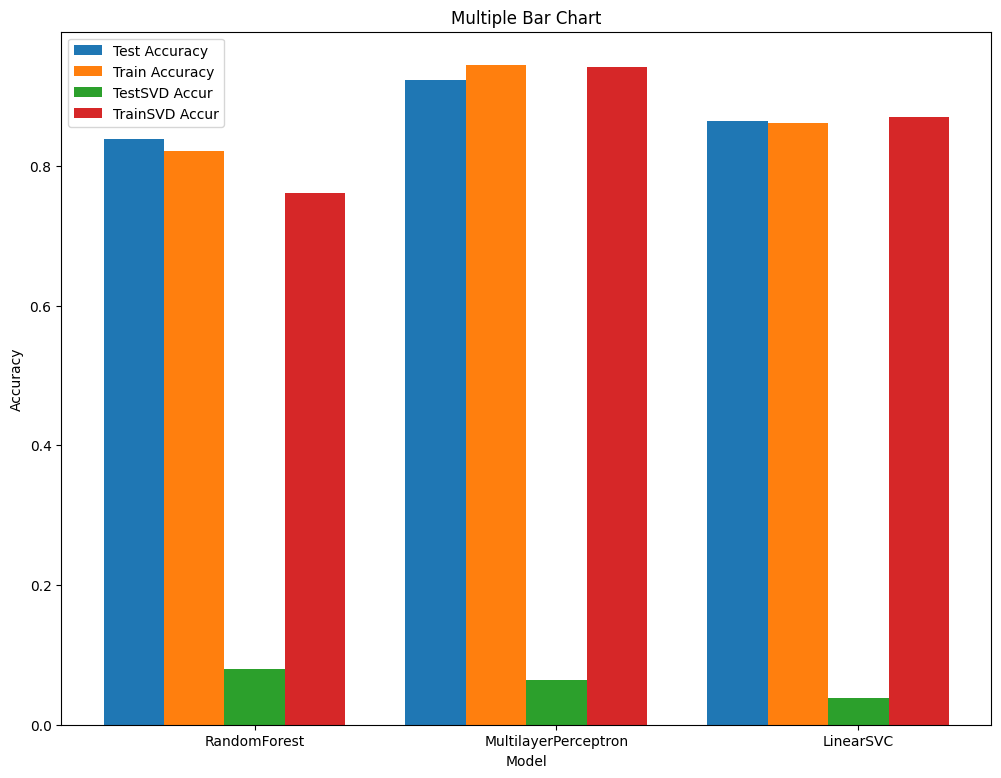

In [ ]:
# Create the figure and add the bars
fig, ax = plt.subplots(figsize=(12, 9))
for i in range(n_bars):
    ax.bar(x_pos + i * bar_width, data[:, i], bar_width, label=labels[i])

# Add the x-axis labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Multiple Bar Chart')
ax.set_xticks(x_pos + bar_width * 2)
ax.set_xticklabels(x_labels)
ax.legend()

# Display the chart
plt.show()

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!jupyter nbconvert --to pdf /content/Final_Project.ipynb

[NbConvertApp] WARNING | pattern '/content/Final_Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--